In [1]:
import pandas as pd
import re
from pandarallel import pandarallel
import nltk
from os import path
from unicodedata import normalize
import seaborn as sns

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

O conjunto de dados possui 15.500 tweets extraídos sobre House of The Dragon utilizando o Twitter Stream Extractor.


Dataset apenas para fins educacionais, para uso em produção recomendo a coleta durante um longo período para diminuir vieses temporais (dia dos pais, situação política, natal)

Referência:
- [Twitter Stream Extractor](https://github.com/AlanTaranti/twitter_stream_extractor)

In [3]:
# Definir caminho do arquivo
filename = "got.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text
0,1561490169131372552,hoje lance o primeiro ep de house of the drago...
0,1561536457717809153,cenas pesadíssimas em house of the dragon
0,1561536925877559297,Ótima primeira impressão de House of The Drago...
0,1561572726791442433,@fabwiano e não me arrependi arrepiei do começ...
0,1561530689102684162,nossa euphoria causou muito mais na minha tl d...
0,1561574490928209920,rapaziada n tá preparada pra quanta cena bruta...
0,1561541592078602241,@BarryKeoghanBRA SURTANDO ATÉ AGORA
0,1561630652776288256,já tá liberado abreviar House of the Dragon pr...
0,1561489216940527616,"HOJE TEM ESTREIA DE HOUSE OF THE DRAGON, E NÃO..."
0,1561657811418873856,@AnisGiulia v- você é… ner- ne- nerdola?


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15500 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      15500 non-null  object
 1   text    15500 non-null  object
dtypes: object(2)
memory usage: 363.3+ KB


In [5]:
def preprocess_data(string, stopwords, stemmer=None):

    # Normalizar a string
    string_tratada = normalize("NFC", string)

    # Converter para minuscula
    string_tratada = string_tratada.lower()

    # Remover referencia a outros usuários
    string_tratada = re.sub("(@[\w]+ | @[\w]+)", " ", string_tratada)

    # Remover new line
    string_tratada = re.sub("\n", " ", string_tratada)

    # Remover as hashtags
    string_tratada = re.sub("(#.+ | #.+)", " ", string_tratada)

    # Remover os links
    string_tratada = re.sub("\w+:\/\/\S+", " ", string_tratada)

    # Remover Numeros
    string_tratada = re.sub("\d", " ", string_tratada)

    # Remover underline
    string_tratada = re.sub("_", " ", string_tratada)

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Tratar Repetições — Permite no máximo 3
    string_tratada = re.sub(r"(.+?)\1{3,}", r"\1\1\1", string_tratada)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [6]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: Esse primeiro ep de House of The Dragon superou as minhas expectativas, eu amei!

Tweet Limpo   : Esse primeiro ep House of The Dragon superou expectativas amei

Tweet Stemed  : ess prim ep hous of the dragon super expect ame


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data["cleaned"].sample(10)

0                       eu hj 22h http t co ienafztu8h
0    bom hous of the dragon n fic olh car bund joa nev
0    n to tank ver hous of the dragon sdd tav ver v...
0    hous of the dragon promet aind viol sex açã go...
0    quer tant assist hous of the dragon hoj carai ...
0    tod mund hyp pra caralh hous of the dragon got...
0    begoniatort entr grup whatsapp sobr hous of th...
0            itsnotdoc da pra assist nunc ter vist got
0        procur alguém assist hous of the dragon comig
0                 luscacalixt simmm amig tô surt manoo
Name: cleaned, dtype: object

# Carregar Pipeline

In [10]:
import pickle

filepath = "models/pre-label-model.pkl"

pipe = pickle.load(open(filepath, "rb"))

# Predição de Sentimento

In [11]:
sentimento = pipe.predict(data["cleaned"])

In [12]:
data["label"] = sentimento

## Demonstração de Classificações

### Positivo

In [13]:
data[data["label"] == 1].sample(10)[["text", "label"]]

,text,label
0,@Robs1906 vem dm,1
0,se a hbo cair na hora sagrada eu cometo um cri...,1
0,House of the Dragon começou muito bem e me deu...,1
0,cheirinho de água oxigenada no set de house of...,1
0,"Tenho HBO Max, mas o ep the House of the Drago...",1
0,“Senti falta do carisma dos personagens de GOT...,1
0,hoje é dia de esquecer os vacilos que cometera...,1
0,HOUSE OF THE DRAGON TÁ MUITO BOM VSF EU TE AMO...,1
0,"Amei esse episódio de House of the dragon, a q...",1
0,@Lxmpzz assisti o primeiro ep ontemmm amei,1


### Neutro

In [14]:
data[data["label"] == 0].sample(10)[["text", "label"]]

,text,label
0,@camilagms_ Duasss,0
0,@heliumchis quero ver tua cara quando souber q...,0
0,House of the Dragon não está à altura da quali...,0
0,"E então Twitter, como foi a estreia de House o...",0
0,Fiz pipoca correndo pra ver House of The Drago...,0
0,o primeiro episódio de house of the dragon abs...,0
0,@DelusionalThom6 KKKKKKKKKKKKKKKKKKKKKK de lei,0
0,vejam got vejam house of the dragon sejam feli...,0
0,eu e vinícius contando as horas pra house of t...,0
0,senti a euforia que eu sentia vendo GOT dnv co...,0


### Negativo

In [15]:
data[data["label"] == -1].sample(10)[["text", "label"]]

,text,label
0,house of the dragon vai ter umas 4/5 temporada...,-1
0,queria muito wue meu wi-fi voltasse eu tenho t...,-1
0,Quem é a pessoa de deus que vai me passar uma ...,-1
0,fdse n quero ver spoilers do house of the drag...,-1
0,@merasnixx Eu esperando o EP todo,-1
0,assisti house of the dragon de madrugada mas e...,-1
0,matt smith tá uma delícia em house of the drag...,-1
0,Deveria dormir p malhar cedinho amanhã mas hoj...,-1
0,@pilulasalgueiro Não veja meu status lá no wpp,-1
0,Eai einnnn #HouseoftheDragon \n\nCASA DO DRAGÃ...,-1


# Visualizações das Predições

In [16]:
porcentagem_positivos = (data["label"] == 1).sum() / data.shape[0]
porcentagem_neutros = (data["label"] == 0).sum() / data.shape[0]
porcentagem_negativos = (data["label"] == -1).sum() / data.shape[0]

print("House of the Dragon: {:.2f}% dos comentários são positivos, enquanto {:.2f}% dos comentários são negativos e {:.2f}% dos comentários são neutros".format(porcentagem_positivos*100, porcentagem_negativos*100, porcentagem_neutros*100))

House of the Dragon: 62.17% dos comentários são positivos, enquanto 24.79% dos comentários são negativos e 13.04% dos comentários são neutros


Text(0.5, 1.0, 'Sentimento dos Comentários de House of the Dragon no Twitter')

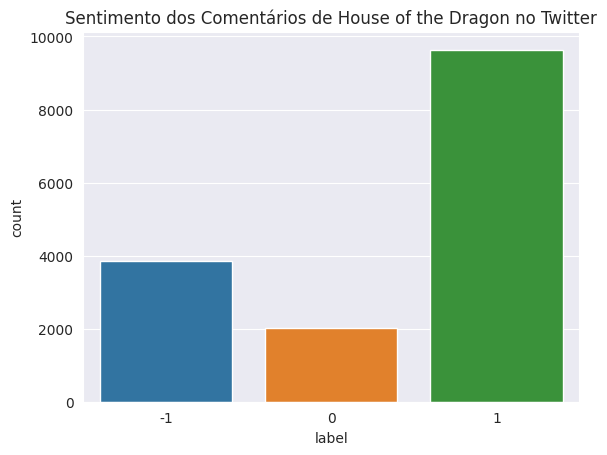

In [17]:
ax = sns.countplot(x="label", data=data)

ax.set_title("Sentimento dos Comentários de House of the Dragon no Twitter")